<a href="https://colab.research.google.com/github/ashaduzzaman-sarker/Image-Classification/blob/main/ShiftViT_A_Vision_Transformer_without_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ShiftViT_A Vision Transformer without Attention

**Author:** [Ashaduzzaman Sarker](https://github.com/ashaduzzaman-sarker/)
<br>
**Date created:** 30/06/2024
**Reference:**

 - ShiftViT : [When Shift Operation Meets Vision Transformer: An Extremely Simple Alternative to Attention Mechanism](
https://doi.org/10.48550/arXiv.2201.10801)

 - [Keras](https://keras.io/examples/vision/shiftvit/)

## **Introduction**

  - Vision Transformers (ViTs) have sparked a wave of research at the intersection of Transformers and Computer Vision (CV).
  - ViTs can simultaneously model long- and short-range dependencies, thanks to the Multi-Head Self-Attention mechanism in the Transformer block.
  - Many researchers believe that the success of ViTs is purely due to the attention layer, and they seldom consider other parts of the ViT model.
  - In the academic paper "When Shift Operation Meets Vision Transformer: An Extremely Simple Alternative to Attention Mechanism," the authors propose demystifying the success of ViTs by introducing a no-parameter operation in place of the attention operation.
  - They replace the attention operation with a shifting operation.
  - This example minimally implements the paper, closely aligning with the author's official implementation.

Explanation:

- **Vision Transformers (ViTs) and Their Impact**:
  - The introduction of ViTs has created significant interest and research in the overlap between Transformers, traditionally used in Natural Language Processing (NLP), and Computer Vision (CV).
  
- **Capabilities of ViTs**:
  - ViTs are notable for their ability to model dependencies at varying scales within an image, from global (long-range) to local (short-range), using the Multi-Head Self-Attention mechanism.
  
- **Common Beliefs**:
  - The success of ViTs is often attributed solely to the attention mechanism. Other components of the ViT architecture are frequently overlooked.
  
- **New Perspective**:
  - The paper "When Shift Operation Meets Vision Transformer" challenges the conventional view by suggesting that the attention mechanism might not be the only reason for ViTs' success.
  
- **Proposed Alternative**:
  - The authors propose an alternative to the attention mechanism—a shifting operation that does not require parameters—potentially simplifying the model.
  
- **Implementation**:
  - The example provided aims to implement the concepts from the paper in a way that is faithful to the authors' original implementation, allowing for a practical exploration of this new approach.

  ![](https://pbs.twimg.com/media/FKE40NAWYAE_lMO.jpg)

## Setup and imports

In [1]:
!pip install -qq -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.9 MB/s eta 0:00:00


In [ ]:
# !pip install --upgrade keras

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import pathlib
import glob

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
# Setting seed for reproducibility
SEED = 42
keras.utils.set_random_seed(SEED)

## Hyperparameters

In [4]:
class Config(object):
  # DATA
  batch_size = 256
  buffer_size = batch_size * 2
  input_shape = (32, 32, 3)
  num_classes = 10

  # AUGMENTATION
  image_size = 48

  # ARCHIECTURE
  patch_size = 4
  projection_dim = 96
  num_shift_blocks_per_stages = [2, 4, 8, 2]
  epsilon = 1e-5
  stochastic_depth_rate = 0.2
  mlp_dropout_rate = 0.2
  num_div = 12
  shift_pixel = 1
  mlp_expand_ratio = 2

  # OPTIMIZER
  lr_start = 1e-5
  lr_max = 1e-3
  weight_decay = 1e-4

  # TRAINING
  epochs = 5 #100

  # INFERENCE
  label_map = {
      0: 'airplane',
      1: 'automobile',
      2: 'bird',
      3: 'cat',
      4: 'deer',
      5: 'dog',
      6: 'frog',
      7: 'horse',
      8: 'ship',
      9: 'truck',
  }
  tf_ds_batch_size = 20

config = Config()

## Load the CIFAR-10 dataset

In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 10s 0us/step


In [6]:
(x_train, y_train), (x_val, y_val) = (
    (x_train[:40000], y_train[:40000]),
    (x_train[40000:], y_train[40000:]),
)

print(f'Training samples: {len(x_train)}')
print(f'Validation samples: {len(x_val)}')
print(f'Testing samples: {len(x_test)}')

Training samples: 40000
Validation samples: 10000
Testing samples: 10000


In [7]:
AUTO = tf.data.AUTOTUNE

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(config.buffer_size).batch(config.batch_size).prefetch(AUTO)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.batch(config.batch_size).prefetch(AUTO)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.batch(config.batch_size).prefetch(AUTO)

## Data Augmentation

In [8]:
def get_augmentation_model():
  # Build the data augmentation model
  data_augmentation = keras.Sequential(
      [
          layers.Resizing(config.input_shape[0] + 20, config.input_shape[0] + 20),
          layers.RandomCrop(config.image_size, config.image_size),
          layers.RandomFlip('horizontal'),
          layers.Rescaling(1 / 255.0)
      ]
  )
  return data_augmentation

## **The ShiftViT architecture**
  - The architecture, as shown in Fig. 1, is inspired by the Swin Transformer: Hierarchical Vision Transformer using Shifted Windows.
  - The authors propose a modular architecture with 4 stages.
  - Each stage operates on its own spatial size, creating a hierarchical architecture.

- **Input Image Processing**
  - An input image of size HxWx3 is split into non-overlapping patches of size 4x4.
  - This is done via the patchify layer, which results in individual tokens of feature size 48 (4x4x3).

- **Stage Composition**
  - Each stage comprises two parts:
    - **Embedding Generation**
    - **Stacked Shift Blocks**

- **Detailed Discussion**
  - The stages and modules are discussed in detail in the sections that follow.

Explanation:

- **Architecture Inspiration**:
  - The proposed architecture is inspired by the Swin Transformer, which uses a hierarchical approach with shifted windows to process images.
  
- **Modular and Hierarchical Design**:
  - The design includes 4 distinct stages, each working on different spatial resolutions of the image. This hierarchical structure allows for capturing features at multiple scales.
  
- **Input Processing**:
  - The input image, typically in RGB format (HxWx3), is divided into small patches of size 4x4 pixels. This process, termed "patchification," converts the image into smaller, manageable tokens with a feature size of 48.
  
- **Components of Each Stage**:
  - Each stage of the architecture is composed of two main parts:
    - **Embedding Generation**: This part is responsible for creating a representation (embedding) of the image patches.
    - **Stacked Shift Blocks**: These blocks perform the core operations, replacing the attention mechanism with shift operations, as proposed by the authors.

![](https://i.imgur.com/CHU40HX.png)

## **The ShiftViT Block**
  - **ShiftViT Block Overview**
    - Each stage in the ShiftViT architecture comprises a Shift Block, as shown in Fig. 2.
    - Fig. 3 provides a detailed view of the Shift Block.

  - **Components of the Shift Block**
    - **Shift Operation**
    - **Linear Normalization**
    - **MLP Layer**

Explanation:

- **ShiftViT Block in Each Stage**:
  - Each stage in the ShiftViT architecture is built around a core component called the Shift Block. This is illustrated in Fig. 2.

- **Detailed View of the Shift Block**:
  - Fig. 3 presents a detailed schematic of the Shift Block, breaking down its internal structure.

- **Key Components**:
  - **Shift Operation**: This operation replaces the traditional attention mechanism, introducing a parameter-free shift-based approach to process the data.
  - **Linear Normalization**: This step normalizes the data linearly, ensuring that the values are scaled appropriately for the next layer.
  - **MLP Layer**: The Multi-Layer Perceptron (MLP) layer provides the computational depth, applying learned transformations to the input data.

![](https://i.imgur.com/0q13pLu.png)

## The MLP block

In [9]:
class MLP(layers.Layer):
  '''
  Get the MLP layer for each shift block

  Args:
      mlp_expand_ratio (int): The ratio with the first feature map is expanded
      mlp_dropout_rate (float): The rate for dropout
  '''
  def __init__(self, mlp_expand_ratio, mlp_dropout_rate, **kwargs):
    super().__init__(**kwargs)
    self.mlp_expand_ratio = mlp_expand_ratio
    self.mlp_dropout_rate = mlp_dropout_rate

  def build(self, input_shape):
    input_channels = input_shape[-1]
    initial_filters = int(self.mlp_expand_ratio * input_channels)

    self.mlp = keras.Sequential(
        [
            layers.Dense(
                units=initial_filters,
                activation='gelu',
            ),
            layers.Dropout(rate=self.mlp_dropout_rate),
            layers.Dense(units=input_channels),
            layers.Dropout(rate=self.mlp_dropout_rate),
        ]
    )

  def call(self, x):
    x = self.mlp(x)
    return x

## The DropPath layer

In [10]:
class DropPath(keras.layers.Layer):
  # A layer that randomly drops residual paths during training

  def __init__(self, drop_path_prob, **kwargs):
    '''
    Args:
        drop_path_prob (float): The probability of dropping a residual path
    '''
    super().__init__(**kwargs)
    self.drop_path_prob = drop_path_prob

  def call(self, x, training=False):
    if training:
      keep_prob = 1 - self.drop_path_prob
      shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)  # Subtract 1 from the length here
      random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
      random_tensor = tf.floor(random_tensor)
      return (x / keep_prob) * random_tensor
    return x

  def get_config(self):
    config = {'drop_path_prob': self.drop_path_prob}
    return config

## Shift operation Block
- **Procedure:**

 - Split the channels with the num_div parameter.
  - Select each of the first four spilts and shift and pad them in the respective directions.
  - After shifting and padding, we concatenate the channel back.

![](https://i.imgur.com/PReeULP.gif)

In [ ]:
# out[:, g * 0:g * 1, :, :-1] = x[:, g * 0:g : 1, :, 1:] # shift left
# out[:, g * 1:g * 2, :, 1:] = x[:, g * 1:g * 2, :, :-1] # shift right
# out[:, g * 2:g * 3, :-1, :] = x[:, g * 2:g * 3, 1:, :] # shift up
# out[:, g * 3:g * 4, 1:, :] = x[:, g * 3:g * 4, :-1, :] # shift down

# out[:, g * 4:, :, :] = x[:, g * 4:, :, :] # no shift

In [11]:
class ShiftViTBlock(layers.Layer):
  '''
  A unit ShiftViT Block:

    Args:
        shift_pixel (int): The number of pixels to shift. Default to 1.
        mlp_expand_ratio (int): The ratio with which MLP features are
                                expanded. Default to 2.
        mlp_dropout_rate (float): The dropout rate used in MLP.
        num_div (int): The number of divisions of the feature map's channel.
                       Totally, 4/num_div of channels will be shifted. Defaults to 12.
        epsilon (float): Epsilon constant.
        drop_path_prob (float): The drop probability for drop path.
    '''

  def __init__( # Fixed: Removed extra indentation
      self,
      epsilon,
      drop_path_prob,
      mlp_dropout_rate,
      num_div=12,
      shift_pixel=1,
      mlp_expand_ratio=2,
      **kwargs,
  ):
      super().__init__(**kwargs)
      self.shift_pixel = shift_pixel
      self.mlp_expand_ratio = mlp_expand_ratio
      self.mlp_dropout_rate = mlp_dropout_rate
      self.num_div = num_div
      self.epsilon = epsilon
      self.drop_path_prob = drop_path_prob

  def build(self, input_shape):
      self.H = input_shape[1]
      self.W = input_shape[2]
      self.C = input_shape[3]
      self.layer_norm = layers.LayerNormalization(epsilon=self.epsilon)
      self.drop_path = (
          DropPath(drop_path_prob=self.drop_path_prob)
          if self.drop_path_prob > 0.0
          else layers.Activation('linear')
      )
      self.mlp = MLP(
          mlp_expand_ratio=self.mlp_expand_ratio,
          mlp_dropout_rate=self.mlp_dropout_rate,
      )

  def get_shift_pad(self, x, mode):
        # Shifts the channels according to the mode chosen
      if mode == 'left':
          offset_height = 0
          offset_width = 0
          target_height = 0
          target_width = self.shift_pixel
      elif mode == 'right':
          offset_height = 0
          offset_width = self.shift_pixel
          target_height = 0
          target_width = self.shift_pixel
      elif mode == 'up':
          offset_height = 0
          offset_width = 0
          target_height = self.shift_pixel
          target_width = 0
      else:
          offset_height = self.shift_pixel
          offset_width = 0
          target_height = self.shift_pixel
          target_width = 0

      crop = tf.image.crop_to_bounding_box(
            x,
            offset_height=offset_height,
            offset_width=offset_width,
            target_height=self.H - target_height,
            target_width=self.W - target_width,
      )
      shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=offset_height,
            offset_width=offset_width,
            target_height=self.H,
            target_width=self.W,
      )
      return shift_pad

  def call(self, x, training=False):
      # Split the feature maps
      x_splits = tf.split(x, num_or_size_splits=self.C // self.num_div, axis=-1)

      # Shift the feature maps
      x_splits[0] = self.get_shift_pad(x_splits[0], mode='left')
      x_splits[1] = self.get_shift_pad(x_splits[1], mode='right')
      x_splits[2] = self.get_shift_pad(x_splits[2], mode='up')
      x_splits[3] = self.get_shift_pad(x_splits[3], mode='down')

      # Concatenate the shifted and unshifted feature maps
      x = tf.concat(x_splits, axis=-1)

      # Add the residual connection
      shortcut = x
      x = shortcut + self.drop_path(self.mlp(self.layer_norm(x)), training=training)
      return x


## The ShiftViT blocks

![](https://i.imgur.com/FKy5NnD.png)


### The PatchMerging layer

In [12]:
class PatchMerging(layers.Layer):
  '''
  The Patch Merging Layer:
  Args:
      epsilon (float): The epsilon constant
  '''
  def __init__(self, epsilon, **kwargs):
    super().__init__(**kwargs)
    self.epsilon = epsilon

  def build(self, input_shape):
    filters = 2 * input_shape[-1]
    self.reduction = layers.Conv2D(
        filters=filters,
        kernel_size=2,
        strides=2,
        padding='same',
        use_bias=False,
    )
    self.layer_norm = layers.LayerNormalization(epsilon=self.epsilon)

  def call(self, x):
    # Apply patch merging algorithm on the feature maps
    x = self.layer_norm(x)
    x = self.reduction(x)
    return x

### Stacked Shift Blocks

In [13]:
# This layer will have a different depth of stacking for different stages on the model
class StackedShiftBlocks(layers.Layer):
  '''
  This layer containing stacked ShiftViTBlocks
  Args:
      epsilon (float): The epsilon constant
      mlp_dropout_rate (float): The dropout rate used in MLP
      num_shift_blocks (int): The number of shift vit used blocks for this stage
      stochastic_depth_rate (float): The maximum drop path rate chosen
      is_merge (boolean): A flag that determines the use of the Patch Merge layer after the shift vit blocks
      num_div (int): The division of channels of the feature map. Defaults to 12
      shift_pixel (int): The number of pixels to shift Defaults to 1
      mlp_expand_ratio (int): The ratio with which the initial dense layer of the MLP is expanded defaults to 2
  '''
  def __init__(
      self,
      epsilon,
      mlp_dropout_rate,
      num_shift_blocks,
      stochastic_depth_rate,
      is_merge,
      num_div=12,
      shift_pixel=1,
      mlp_expand_ratio=2,
      **kwargs,
  ):
      super().__init__(**kwargs)
      self.epsilon = epsilon
      self.mlp_dropout_rate = mlp_dropout_rate
      self.num_shift_blocks = num_shift_blocks
      self.stochastic_depth_rate = stochastic_depth_rate
      self.is_merge = is_merge
      self.num_div = num_div
      self.shift_pixel = shift_pixel
      self.mlp_expand_ratio = mlp_expand_ratio

  def build(self, input_shape):
    # Calculate stochastic depth probabilities
    dpr = [
        x
        for x in np.linspace(
            start=0, stop=self.stochastic_depth_rate, num=self.num_shift_blocks
        )
    ]

    # Build the shift blocks as a list of ShiftViT Blocks
    self.shift_blocks = list()
    for num in range(self.num_shift_blocks):
      self.shift_blocks.append(
          ShiftViTBlock(
              num_div=self.num_div,
              epsilon=self.epsilon,
              drop_path_prob=dpr[num],
              mlp_dropout_rate=self.mlp_dropout_rate,
              shift_pixel=self.shift_pixel,
              mlp_expand_ratio=self.mlp_expand_ratio,
          )
      )

      if self.is_merge:
        self.patch_merge = PatchMerging(epsilon=self.epsilon)

  def call(self, x, training=False):
    for shift_block in self.shift_blocks:
      x = shift_block(x, training=training)
    if self.is_merge:
      x = self.patch_merge(x)
    return x

  # Since this is a custom layer, we need to overwrite get_config(), so that model can easily be saved and loaded after training
  def get_config(self):
    config = super().get_config()
    config.update(
        {
            'epsilon': self.epsilon,
            'mlp_dropout_rate': self.mlp_dropout_rate,
            'num_shift_blocks': self.num_shift_blocks,
            'stochastic_depth_rate': self.stochastic_depth_rate,
            'is_merge': self.is_merge,
            'num_div': self.num_div,
            'shift_pixel': self.shift_pixel,
            'mlp_expand_ratio': self.mlp_expand_ratio,
        }
    )
    return config

## The ShiftViT model

In [20]:
class ShiftViTModel(keras.Model):
    """The ShiftViT Model.

    Args:
        data_augmentation (keras.Model): A data augmentation model.
        projected_dim (int): The dimension to which the patches of the image are
            projected.
        patch_size (int): The patch size of the images.
        num_shift_blocks_per_stages (list[int]): A list of all the number of shit
            blocks per stage.
        epsilon (float): The epsilon constant.
        mlp_dropout_rate (float): The dropout rate used in the MLP block.
        stochastic_depth_rate (float): The maximum drop rate probability.
        num_div (int): The number of divisions of the channesl of the feature
            map. Defaults to 12.
        shift_pixel (int): The number of pixel to shift. Default to 1.
        mlp_expand_ratio (int): The ratio with which the initial mlp dense layer
            is expanded to. Defaults to 2.
    """

    def __init__(
        self,
        data_augmentation,
        projected_dim,
        patch_size,
        num_shift_blocks_per_stages,
        epsilon,
        mlp_dropout_rate,
        stochastic_depth_rate,
        num_div=12,
        shift_pixel=1,
        mlp_expand_ratio=2,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.data_augmentation = data_augmentation
        self.patch_projection = layers.Conv2D(
            filters=projected_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="same",
        )
        self.stages = list()
        for index, num_shift_blocks in enumerate(num_shift_blocks_per_stages):
            if index == len(num_shift_blocks_per_stages) - 1:
                # This is the last stage, do not use the patch merge here.
                is_merge = False
            else:
                is_merge = True
            # Build the stages.
            self.stages.append(
                StackedShiftBlocks(
                    epsilon=epsilon,
                    mlp_dropout_rate=mlp_dropout_rate,
                    num_shift_blocks=num_shift_blocks,
                    stochastic_depth_rate=stochastic_depth_rate,
                    is_merge=is_merge,
                    num_div=num_div,
                    shift_pixel=shift_pixel,
                    mlp_expand_ratio=mlp_expand_ratio,
                )
            )
        self.global_avg_pool = layers.GlobalAveragePooling2D()

        self.classifier = layers.Dense(config.num_classes)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "data_augmentation": self.data_augmentation,
                "patch_projection": self.patch_projection,
                "stages": self.stages,
                "global_avg_pool": self.global_avg_pool,
                "classifier": self.classifier,
            }
        )
        return config

    def _calculate_loss(self, data, training=False):
        (images, labels) = data

        # Augment the images
        augmented_images = self.data_augmentation(images, training=training)

        # Create patches and project the pathces.
        projected_patches = self.patch_projection(augmented_images)

        # Pass through the stages
        x = projected_patches
        for stage in self.stages:
            x = stage(x, training=training)

        # Get the logits.
        x = self.global_avg_pool(x)
        logits = self.classifier(x)

        # Calculate the loss and return it.
        total_loss = self.compiled_loss(labels, logits)
        return total_loss, labels, logits

    def train_step(self, inputs):
        with tf.GradientTape() as tape:
            total_loss, labels, logits = self._calculate_loss(
                data=inputs, training=True
            )

        # Apply gradients.
        train_vars = [
            self.data_augmentation.trainable_variables,
            self.patch_projection.trainable_variables,
            self.global_avg_pool.trainable_variables,
            self.classifier.trainable_variables,
        ]
        train_vars = train_vars + [stage.trainable_variables for stage in self.stages]

        # Optimize the gradients.
        grads = tape.gradient(total_loss, train_vars)
        trainable_variable_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                trainable_variable_list.append((g, v))
        self.optimizer.apply_gradients(trainable_variable_list)

        # Update the metrics
        self.compiled_metrics.update_state(labels, logits)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        _, labels, logits = self._calculate_loss(data=data, training=False)

        # Update the metrics
        self.compiled_metrics.update_state(labels, logits)
        return {m.name: m.result() for m in self.metrics}

    def call(self, images):
        augmented_images = self.data_augmentation(images)
        x = self.patch_projection(augmented_images)
        for stage in self.stages:
            x = stage(x, training=False)
        x = self.global_avg_pool(x)
        logits = self.classifier(x)
        return logits

## Instantiate the model

In [21]:
model = ShiftViTModel(
    data_augmentation=get_augmentation_model(),
    projected_dim=config.projection_dim,
    patch_size=config.patch_size,
    num_shift_blocks_per_stages=config.num_shift_blocks_per_stages,
    epsilon=config.epsilon,
    mlp_dropout_rate=config.mlp_dropout_rate,
    stochastic_depth_rate=config.stochastic_depth_rate,
    num_div=config.num_div,
    shift_pixel=config.shift_pixel,
    mlp_expand_ratio=config.mlp_expand_ratio,
)

## Learning rate schedule

In [24]:
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
  # A LearningRateSchedule that uses a warmup cosine decay schedule

  def __init__(self, lr_start, lr_max, warmup_steps, total_steps):
    '''
    Args:
        lr_start (float): The initial learning rate
        lr_max (float): The maximum learning rate
        warmup_steps (int): The number of warmup steps
        total_steps (int): The total number of steps
    '''
    super().__init__()
    self.lr_start = lr_start
    self.lr_max = lr_max
    self.warmup_steps = warmup_steps
    self.total_steps = total_steps
    self.pi = tf.constant(np.pi)

  def __call__(self, step):
    # Check wether the total number of steps is larger than the warmup steps
    if self.total_steps < self.warmup_steps:
      raise ValueError(
          f'Total number of steps {self.total_steps} must be' +
          f'larger or equal to warmup steps {self.warmup_steps}.'
      )

    # 'cos_annealed_lr'
    cos_annealed_lr = tf.cos(
        self.pi
        * (tf.cast(step, tf.float32) - self.warmup_steps)
        / tf.cast(self.total_steps - self.warmup_steps, tf.float32)
    )

    learning_rate = 0.5 * self.lr_max * (1 + cos_annealed_lr)

    # Check weather warmup step is more than 0
    if self.warmup_steps > 0:
      if self.lr_max < self.lr_start:
        raise ValueError(
            f'lr_srart {self.lr_start} must be smaller or' +
            f'equal to lr_max {self.lr_max}.'
        )

      slope = (self.lr_max - self.lr_start) / self.warmup_steps

      warmup_rate = slope * tf.cast(step, tf.float32) + self.lr_start

      learning_rate = tf.where(
          step < self.warmup_steps,
          warmup_rate,
          learning_rate,
      )

    return tf.where(
        step > self.total_steps, 0.0, learning_rate, name='learning_rate'
    )

  def get_config(self):
    config = {
        'lr_start': self.lr_start,
        'lr_max': self.lr_max,
        'total_steps': self.total_steps,
        'warmup_steps': self.warmup_steps,
    }
    return config

## Compile and train the model

In [25]:
sample_ds, _ = next(iter(train_ds))
model(sample_ds, training=False)

total_steps = int((len(x_train) / config.batch_size) * config.epochs)

warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)

scheduled_lrs = WarmUpCosine(
    lr_start=1e-5,
    lr_max=1e-3,
    warmup_steps=warmup_steps,
    total_steps=total_steps,
)

optimizer = tfa.optimizers.AdamW(
    learning_rate=scheduled_lrs, weight_decay=1e-2
)

model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), # Fixed typo here
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
        keras.metrics.SparseTopKCategoricalAccuracy(5, name='top-5-accuracy'),
    ],
)

history = model.fit(
    train_ds,
    epochs=config.epochs,
    validation_data=val_ds,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            mode='auto',
        )
    ],
)

print('TESTING')
loss, acc_top1, acc_top5 = model.evaluate(test_ds)
print(f'loss: {loss:0.02f}')
print(f'Top 1 test accuracy: {acc_top1*100:0.2f}%')
print(f'Top 5 test accuracy: {acc_top5*100:0.2f}%')

Epoch 1/5
157/157 [==============================] - 930s 6s/step - loss: 2.0639 - accuracy: 0.2480 - top-5-accuracy: 0.7374 - val_loss: 1.8980 - val_accuracy: 0.3198 - val_top-5-accuracy: 0.8225
Epoch 2/5
157/157 [==============================] - 897s 6s/step - loss: 1.9060 - accuracy: 0.3098 - top-5-accuracy: 0.8201 - val_loss: 1.8782 - val_accuracy: 0.3134 - val_top-5-accuracy: 0.8181
Epoch 3/5
157/157 [==============================] - 893s 6s/step - loss: 1.9061 - accuracy: 0.3065 - top-5-accuracy: 0.8219 - val_loss: 1.9600 - val_accuracy: 0.2926 - val_top-5-accuracy: 0.8045
Epoch 4/5
157/157 [==============================] - 1129s 7s/step - loss: 1.9643 - accuracy: 0.2960 - top-5-accuracy: 0.8131 - val_loss: 2.0548 - val_accuracy: 0.2750 - val_top-5-accuracy: 0.8023
Epoch 5/5
157/157 [==============================] - 1016s 6s/step - loss: 2.2271 - accuracy: 0.1811 - top-5-accuracy: 0.6819 - val_loss: 2.3026 - val_accuracy: 0.0952 - val_top-5-accuracy: 0.5018
TESTING
40/40 [===

- train on 50 epochs to get better results

## Save trained model

In [26]:
model.save('ShiftViT')

## Model inference

In [28]:
# Download sample data for inference
!wget -q 'https://tinyurl.com/2p9483sw' -O inference_set.zip
!unzip -q inference_set.zip

In [29]:
# Load saved model
saved_model = tf.keras.models.load_model(
    'ShiftViT',
    custom_objects={'WarmUpCosine': WarmUpCosine, 'AdamW': tfa.optimizers.AdamW},
)

In [30]:
# Utility functions for inference
def process_image(img_path):
  img = tf.io.read_file(img_path)

  img = tf.io.decode_jpeg(img, channels=3)

  img = tf.image.resize(
      img, [config.input_shape[0], config.input_shape[1]], method='nearest'
  )
  return img

def create_tf_dataset(image_dir):
  data_dir = pathlib.Path(image_dir)

  predict_ds = tf.data.Dataset.list_files(str(data_dir / '*.jpg'), shuffle=False)

  predict_ds = predict_ds.map(process_image, num_parallel_calls=AUTO)

  predict_ds = predict_ds.batch(config.tf_ds_batch_size).prefetch(AUTO)
  return predict_ds

def predict(predict_ds):
  logits = saved_model.predict(predict_ds)

  probabilities = tf.nn.softmax(logits)
  return probabilities

def get_predicted_class(probabilities):
  pred_label = np.argmax(probabilities)
  predicted_class = config.label_map[pred_label]
  return predicted_class

def get_confidence_scores(probabilities):
  labels = np.argsort(probabilities)[::-1]
  confidences = {
      config.label_map[label]: np.round((probabilities[label]) * 100, 2)
      for label in labels
  }

  return confidences

In [31]:
# Get predictions
img_dir = 'inference_set'
predict_ds = create_tf_dataset(img_dir)
probabilities = predict(predict_ds)
print(f'probabilities: {probabilities[0]}')

confidences = get_confidence_scores(probabilities[0])
print(confidences)

1/1 [==============================] - 2s 2s/step
probabilities: [0.10011393 0.10000818 0.10014922 0.10013884 0.09985273 0.09997135
 0.09978589 0.09992218 0.10000063 0.10005701]
{'bird': 10.01, 'cat': 10.01, 'airplane': 10.01, 'truck': 10.01, 'automobile': 10.0, 'ship': 10.0, 'dog': 10.0, 'horse': 9.99, 'deer': 9.99, 'frog': 9.98}


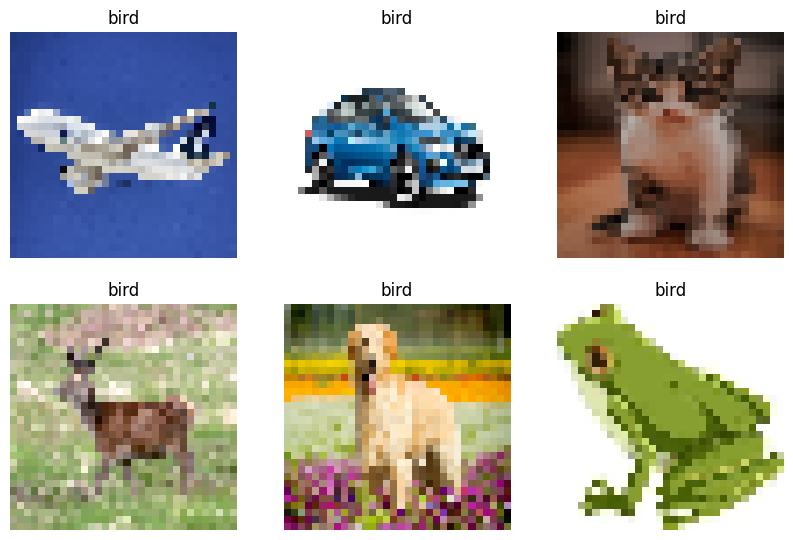

In [32]:
# View predictions
plt.figure(figsize=(10, 10))
for images in predict_ds:
  for i in range(min(6, probabilities.shape[0])):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    predicted_class = get_predicted_class(probabilities[i])
    plt.title(predicted_class)
    plt.axis('off')